In [1]:
from google.colab import drive
import os

drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/BERT')

Mounted at /content/drive/


In [ ]:
!nvidia-smi

Mon Aug 19 15:20:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install pip==23.1
!pip install omegaconf==2.0.6 --use-deprecated=legacy-resolver
!pip install fairseq
!pip install vncorenlp
!pip install fastBPE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 29.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.8 MB/

In [3]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torch import nn
import json
import numpy as np
import pickle
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from transformers import *
import torch
import matplotlib.pyplot as plt
import torch.utils.data
import torch.nn.functional as F
import argparse
from transformers.modeling_utils import *
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
from vncorenlp import VnCoreNLP

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions he

In [4]:
train_path = '/content/drive/MyDrive/BERT/train.csv'
dict_path = "/content/drive/MyDrive/BERT/PhoBERT_base_transformers/dict.txt"
config_path = "/content/drive/MyDrive/BERT/PhoBERT_base_transformers/config.json"
rdrsegmenter_path = "/content/drive/My Drive/BERT/vncorenlp/VnCoreNLP-1.1.1.jar"
pretrained_path = '/content/drive/MyDrive/BERT/PhoBERT_base_transformers/model.bin'
max_sequence_length = 256
batch_size = 24
accumulation_steps = 5
epochs = 20
fold = 4
seed = 69
lr = 3e-5
ckpt_path = '/content/drive/MyDrive/BERT/'
bpe_codes = "/content/drive/MyDrive/BERT/PhoBERT_base_transformers/bpe.codes"

In [5]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes',
    default="/content/drive/My Drive/BERT/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)

args, unknown = parser.parse_known_args()
bpe = fastBPE(args)
rdrsegmenter = VnCoreNLP("/content/drive/My Drive/BERT/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

seed_everything(69)

In [7]:
import torch
from torch import nn
from transformers import *

class RobertaForAIViVN(BertPreTrainedModel):
   config_class = RobertaConfig
   base_model_prefix = "roberta"
   def __init__(self, config):
       super(RobertaForAIViVN, self).__init__(config)
       self.num_labels = config.num_labels
       self.roberta = RobertaModel(config)
       self.qa_outputs = nn.Linear(4*config.hidden_size, self.num_labels)

       self.init_weights()

   def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                start_positions=None, end_positions=None):

       outputs = self.roberta(input_ids,
                            attention_mask=attention_mask,
#                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
       cls_output = torch.cat((outputs[2][-1][:,0, ...],outputs[2][-2][:,0, ...], outputs[2][-3][:,0, ...], outputs[2][-4][:,0, ...]),-1)
       logits = self.qa_outputs(cls_output)
       return logits

In [8]:
# Load model
config = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/BERT/PhoBERT_base_transformers/config.json",
    from_tf=False,
    num_labels=3,
    output_hidden_states=True,
    attn_implementation="eager"
)
model = RobertaForAIViVN(config)

loading configuration file /content/drive/My Drive/BERT/PhoBERT_base_transformers/config.json
You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "abs

In [ ]:
model.cuda()

In [9]:
if torch.cuda.device_count():
    print(f"Training using {torch.cuda.device_count()} gpus")
    model_bert = nn.DataParallel(model)
    tsfm = model_bert.module.roberta
else:
    tsfm = model.roberta

In [10]:
# Load the dictionary
vocab = Dictionary()
vocab.add_from_file(dict_path)

In [11]:
train_df = pd.read_csv(train_path, sep=',').fillna("###")

In [12]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])
train_df['label'] = label_encoder.transform(train_df['label'])

In [13]:
train_df['label'][0]

1

In [14]:
def convert_lines(series, vocab, bpe, max_sequence_length):
    num_samples = len(series)
    outputs = np.zeros((num_samples, max_sequence_length))

    cls_id = 0
    eos_id = 2
    pad_id = 1

    for idx in tqdm(range(num_samples), total=num_samples):
        text = series.iloc[idx]
        subwords = bpe.encode('<s> ' + text + ' </s>')
        input_ids = vocab.encode_line(subwords, append_eos=False, add_if_not_exist=False).long().tolist()
        if len(input_ids) > max_sequence_length:
            input_ids = input_ids[:max_sequence_length]
            input_ids[-1] = eos_id
        else:
            input_ids = input_ids + [pad_id] * (max_sequence_length - len(input_ids))
        outputs[idx, :] = np.array(input_ids)

    return outputs

In [15]:
from tqdm import tqdm
tqdm.pandas()

# Chuyển đổi cột 'comment' sang dạng chuỗi
train_df['comment'] = train_df['comment'].astype(str)

train_df["comment"] = train_df['comment'].progress_apply(lambda x: ' '.join([' '.join(sent) for sent in rdrsegmenter.tokenize(x)]))

y = train_df['label'].values

X_train = convert_lines(train_df["comment"], vocab, bpe, max_sequence_length)

100%|██████████| 7786/7786 [00:05<00:00, 1521.97it/s]


In [16]:
X_train[0]

array([6.3117e+04, 1.3020e+03, 8.8400e+02, 2.1790e+03, 1.0290e+03,
       5.0000e+01, 3.6340e+03, 4.2410e+03, 1.8800e+02, 2.2004e+04,
       2.6690e+03, 4.1500e+02, 2.1790e+03, 5.0000e+01, 4.3710e+03,
       2.7700e+02, 4.7500e+02, 7.0000e+01, 6.3117e+04, 7.2690e+03,
       1.3020e+03, 8.8400e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e

In [17]:
def preprocess_data(X_train, y):
    # Kiểm tra và chuyển đổi dữ liệu trong X_train
    if isinstance(X_train, np.ndarray) and X_train.dtype == np.object_:
        X_train = np.array([np.array(x, dtype=np.int64) for x in X_train])
    if isinstance(y, np.ndarray) and y.dtype == np.object_:
        y = np.array(y, dtype=np.int64)
    return X_train, y

X_train, y = preprocess_data(X_train, y)

In [18]:
# Creating optimizer and lr schedulers
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
num_train_optimization_steps = int(epochs*len(train_df)/batch_size/accumulation_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_train_optimization_steps)  # PyTorch scheduler
scheduler0 = get_constant_schedule(optimizer)  # PyTorch scheduler

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
def softmax(x):
    """Tính toán hàm softmax cho mảng đầu vào x."""
    e_x = np.exp(x - np.max(x))  # Sử dụng np.max(x) để cải thiện sự ổn định số học
    return e_x / e_x.sum(axis=1, keepdims=True)

In [ ]:
if not os.path.exists(ckpt_path):
    os.mkdir(ckpt_path)


splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y))
for fold, (train_idx, val_idx) in enumerate(splits):
    print("Training for fold {}".format(fold))
    best_score = 0
    if fold != fold:
        continue

    # Create train and validation datasets
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train[train_idx],dtype=torch.long), torch.tensor(y[train_idx],dtype=torch.long))
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train[val_idx],dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))
    tq = tqdm(range(epochs + 1))

    # Đóng băng (freeze) các tham số của một số lớp con của mô hình
    for child in tsfm.children():
        for param in child.parameters():
            if not param.requires_grad:
                print("whoopsies")
            param.requires_grad = False
    frozen = True


    # Điều chỉnh trạng thái huấn luyện của mô hình trong mỗi epoch
    for epoch in tq:
        if epoch > 0 and frozen:
            for child in tsfm.children():
                for param in child.parameters():
                    param.requires_grad = True
            frozen = False
            del scheduler0
            torch.cuda.empty_cache()

        val_preds = None
        # Khởi tạo DataLoader cho tập train và valid
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        avg_loss = 0.
        avg_accuracy = 0.
        # Đặt gradient của các tham số mô hình về 0.0
        optimizer.zero_grad()


        # Thực hiện huấn luyện mô hình, tính toán mất mát, cập nhật trọng số và theo dõi tiến trình huấn luyện.

        criterion = nn.CrossEntropyLoss()
        pbar = tqdm(enumerate(train_loader),total=len(train_loader),leave=False)
        for i, (x_batch, y_batch) in pbar:
          model.train()
          y_pred = model(x_batch.cuda(), attention_mask=(x_batch > 0).cuda())

          y_batch = y_batch.cuda()  # Nhãn thực tế

          # Tính toán mất mát
          loss = criterion(y_pred, y_batch)
          loss.backward()

          if i % accumulation_steps == 0 or i == len(pbar) - 1:
              optimizer.step()
              optimizer.zero_grad()
              if not frozen:
                  scheduler.step()
              else:
                  scheduler0.step()

          lossf = loss.item()
          pbar.set_postfix(loss=lossf)
          avg_loss += loss.item() / len(train_loader)

        # Đánh giá mô hình trên tập validation, thu thập và lưu trữ các dự đoán của mô hình, và áp dụng hàm softmax để chuyển đổi các giá trị logits thành xác suất.
        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False)
        for i, (x_batch, y_batch) in pbar:
            model.eval()  # Đặt mô hình ở chế độ đánh giá
            with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
                y_pred = model(x_batch.cuda(), attention_mask=(x_batch > 0).cuda())

            # Giả sử y_pred có kích thước [batch_size, num_classes]
            y_pred = y_pred.cpu().numpy()  # Chuyển dự đoán về CPU và NumPy
            val_preds = np.atleast_1d(y_pred) if val_preds is None else np.concatenate([val_preds, np.atleast_1d(y_pred)])

        # Áp dụng softmax cho dự đoán
        val_preds = softmax(val_preds)  # Đảm bảo softmax cho lớp cuối cùng

        # Tính điểm F1 và AUC
        y_true = y[val_idx]
        y_pred_labels = np.argmax(val_preds, axis=1)  # Chọn lớp với xác suất cao nhất
        score = f1_score(y_true, y_pred_labels, average='weighted')  # Tính điểm F1 với lựa chọn trung bình

        print(f"\nAUC = {roc_auc_score(y_true, val_preds, multi_class='ovr'):.4f}, F1 score = {score:.4f}")

        # Lưu mô hình nếu điểm F1 tốt nhất hiện tại
        if score >= best_score:
            torch.save(model.state_dict(), os.path.join(ckpt_path, f"model_{fold}.bin"))
            best_score = score

In [20]:
import torch
torch.save(model.state_dict(), "model_weights.pth")

In [21]:
# torch.save(model, "model_full.pth")

In [22]:
from sklearn.preprocessing import LabelEncoder
test_df = pd.read_csv('/content/drive/MyDrive/BERT/test.csv', sep=',').fillna("###")

In [23]:
label_encoder = LabelEncoder()
label_encoder.fit(test_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

In [24]:
test_df['label'][0]

2

In [25]:
test_df.columns

Index(['comment', 'n_star', 'date_time', 'label', 'positive_count',
       'neutral_count', 'negative_count'],
      dtype='object')

In [26]:
print(test_df.shape)

(2224, 7)


In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Đọc dữ liệu test từ tệp CSV
test_df = pd.read_csv('/content/drive/MyDrive/BERT/test.csv', sep=',').fillna("###")
label_encoder = LabelEncoder()
label_encoder.fit(test_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

test_df['comment'] = test_df['comment'].astype(str)

test_df["comment"] = test_df['comment'].progress_apply(lambda x: ' '.join([' '.join(sent) for sent in rdrsegmenter.tokenize(x)]))

y_test = test_df['label'].values

X_test = convert_lines(test_df["comment"], vocab, bpe, max_sequence_length)

100%|██████████| 2224/2224 [00:02<00:00, 983.17it/s] 


loading configuration file /content/drive/My Drive/BERT/PhoBERT_base_transformers/config.json
You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "abs

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


  2%|▏         | 2/93 [01:08<51:10, 33.74s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


  3%|▎         | 3/93 [01:35<45:56, 30.63s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


  4%|▍         | 4/93 [02:04<44:28, 29.99s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


  5%|▌         | 5/93 [02:32<42:47, 29.17s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


  6%|▋         | 6/93 [03:02<42:36, 29.39s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


  8%|▊         | 7/93 [03:29<40:50, 28.50s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


  9%|▊         | 8/93 [03:57<40:10, 28.35s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 10%|▉         | 9/93 [04:23<38:56, 27.82s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 11%|█         | 10/93 [04:50<38:04, 27.53s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 12%|█▏        | 11/93 [05:21<38:51, 28.44s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 13%|█▎        | 12/93 [05:46<37:15, 27.60s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 14%|█▍        | 13/93 [06:14<36:57, 27.72s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 15%|█▌        | 14/93 [06:42<36:38, 27.83s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 16%|█▌        | 15/93 [07:08<35:15, 27.12s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 17%|█▋        | 16/93 [07:36<35:10, 27.41s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 18%|█▊        | 17/93 [08:04<34:56, 27.59s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 19%|█▉        | 18/93 [08:30<33:44, 27.00s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 20%|██        | 19/93 [08:58<33:42, 27.33s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 22%|██▏       | 20/93 [09:26<33:30, 27.54s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 23%|██▎       | 21/93 [09:51<32:20, 26.95s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 24%|██▎       | 22/93 [10:19<32:18, 27.31s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 25%|██▍       | 23/93 [10:47<32:07, 27.54s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 26%|██▌       | 24/93 [11:18<32:32, 28.30s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 27%|██▋       | 25/93 [11:45<31:43, 28.00s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 28%|██▊       | 26/93 [12:13<31:22, 28.09s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 29%|██▉       | 27/93 [12:40<30:38, 27.85s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 30%|███       | 28/93 [13:07<29:49, 27.53s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 31%|███       | 29/93 [13:36<29:37, 27.78s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 32%|███▏      | 30/93 [14:03<29:07, 27.74s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 33%|███▎      | 31/93 [14:30<28:14, 27.34s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 34%|███▍      | 32/93 [14:58<28:03, 27.60s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 35%|███▌      | 33/93 [15:26<27:40, 27.68s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 37%|███▋      | 34/93 [15:52<26:44, 27.20s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 38%|███▊      | 35/93 [16:20<26:31, 27.44s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 39%|███▊      | 36/93 [16:48<26:19, 27.70s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 40%|███▉      | 37/93 [17:14<25:20, 27.16s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 41%|████      | 38/93 [17:42<25:11, 27.48s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 42%|████▏     | 39/93 [18:10<24:56, 27.71s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 43%|████▎     | 40/93 [18:37<24:04, 27.25s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 44%|████▍     | 41/93 [19:04<23:46, 27.43s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 45%|████▌     | 42/93 [19:33<23:31, 27.67s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 46%|████▌     | 43/93 [19:59<22:44, 27.30s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 47%|████▋     | 44/93 [20:27<22:21, 27.37s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 48%|████▊     | 45/93 [20:55<22:07, 27.66s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 49%|████▉     | 46/93 [21:25<22:15, 28.41s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 51%|█████     | 47/93 [21:53<21:44, 28.37s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 52%|█████▏    | 48/93 [22:22<21:15, 28.35s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 53%|█████▎    | 49/93 [22:50<20:45, 28.32s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 54%|█████▍    | 50/93 [23:16<19:46, 27.58s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 55%|█████▍    | 51/93 [23:44<19:27, 27.80s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 56%|█████▌    | 52/93 [24:12<19:05, 27.95s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 57%|█████▋    | 53/93 [24:38<18:14, 27.37s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 58%|█████▊    | 54/93 [25:07<17:55, 27.59s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 59%|█████▉    | 55/93 [25:35<17:36, 27.79s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 60%|██████    | 56/93 [26:01<16:53, 27.40s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 61%|██████▏   | 57/93 [26:29<16:29, 27.49s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 62%|██████▏   | 58/93 [26:57<16:10, 27.73s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 63%|██████▎   | 59/93 [27:24<15:33, 27.46s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 65%|██████▍   | 60/93 [27:51<15:04, 27.41s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 66%|██████▌   | 61/93 [28:22<15:03, 28.23s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 67%|██████▋   | 62/93 [28:49<14:25, 27.93s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 68%|██████▊   | 63/93 [29:16<13:50, 27.69s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 69%|██████▉   | 64/93 [29:44<13:28, 27.87s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 70%|██████▉   | 65/93 [30:12<12:56, 27.74s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 71%|███████   | 66/93 [30:38<12:18, 27.35s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 72%|███████▏  | 67/93 [31:06<11:58, 27.63s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 73%|███████▎  | 68/93 [31:38<12:01, 28.84s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 74%|███████▍  | 69/93 [32:04<11:14, 28.11s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 75%|███████▌  | 70/93 [32:32<10:45, 28.07s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 76%|███████▋  | 71/93 [33:01<10:18, 28.12s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 77%|███████▋  | 72/93 [33:27<09:42, 27.71s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 78%|███████▊  | 73/93 [33:55<09:12, 27.63s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 80%|███████▉  | 74/93 [34:23<08:48, 27.84s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 81%|████████  | 75/93 [34:50<08:16, 27.60s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 82%|████████▏ | 76/93 [35:17<07:45, 27.40s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 83%|████████▎ | 77/93 [35:45<07:22, 27.67s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 84%|████████▍ | 78/93 [36:13<06:55, 27.67s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 85%|████████▍ | 79/93 [36:39<06:21, 27.21s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 86%|████████▌ | 80/93 [37:08<05:58, 27.54s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 87%|████████▋ | 81/93 [37:36<05:33, 27.77s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 88%|████████▊ | 82/93 [38:02<04:59, 27.19s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 89%|████████▉ | 83/93 [38:30<04:35, 27.53s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 90%|█████████ | 84/93 [38:58<04:09, 27.76s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 91%|█████████▏| 85/93 [39:24<03:38, 27.25s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 92%|█████████▏| 86/93 [39:53<03:12, 27.51s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 94%|█████████▎| 87/93 [40:21<02:46, 27.69s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 95%|█████████▍| 88/93 [40:47<02:17, 27.41s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 96%|█████████▌| 89/93 [41:15<01:49, 27.44s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 97%|█████████▋| 90/93 [41:43<01:23, 27.69s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 98%|█████████▊| 91/93 [42:10<00:55, 27.51s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


 99%|█████████▉| 92/93 [42:37<00:27, 27.39s/it]

Predictions shape: torch.Size([24])
Labels shape: torch.Size([24])


100%|██████████| 93/93 [42:55<00:00, 27.69s/it]

Predictions shape: torch.Size([16])
Labels shape: torch.Size([16])


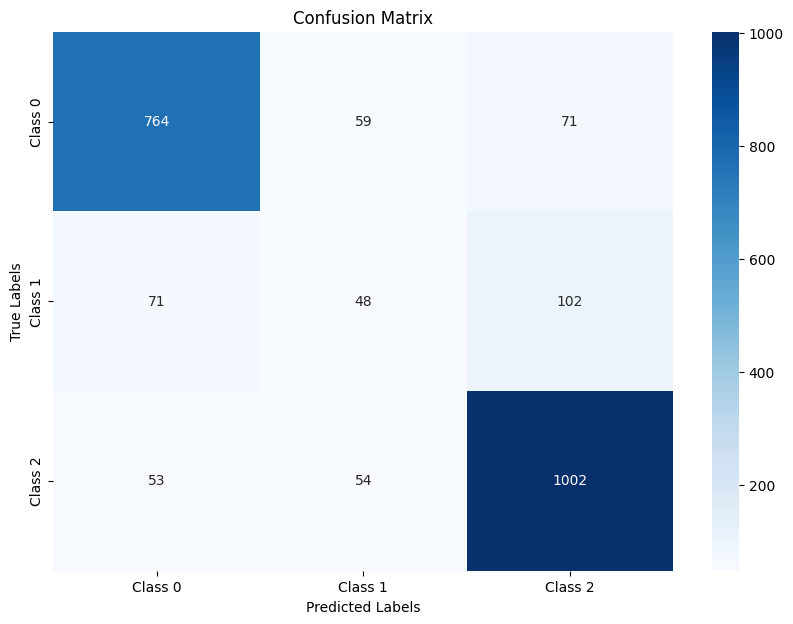

In [28]:
# Chuyển đổi dữ liệu test thành tensor
test_inputs = torch.tensor(X_test, dtype=torch.long)
test_labels = torch.tensor(y_test, dtype=torch.long)

# Tạo dataset và dataloader
test_dataset = TensorDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

cofig = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/BERT/PhoBERT_base_transformers/config.json",
    from_tf=False,
    num_labels=3,
    output_hidden_states=True,
    attn_implementation="eager"
)
model = RobertaForAIViVN(config)
model.load_state_dict(torch.load('/content/drive/MyDrive/BERT/model_0.bin', map_location=torch.device('cpu')))
model.eval()  # Đặt mô hình ở chế độ đánh giá

all_preds = []
all_labels = []


with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids, labels = batch
        outputs = model(input_ids)
        if isinstance(outputs, torch.Tensor):
            logits = outputs
        else:
            logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        print(f'Predictions shape: {predictions.shape}')
        print(f'Labels shape: {labels.shape}')

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tính toán confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()